In [1]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
print(tf.__version__)

1.15.0


In [2]:
tf.enable_eager_execution()

In [3]:

import string
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from keras.backend.tensorflow_backend import set_session
import keras
import sys, time, os, warnings 
warnings.filterwarnings("ignore")
import re

import numpy as np
import pandas as pd 
from PIL import Image
import pickle
from collections import Counter
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import shuffle
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Using TensorFlow backend.


In [4]:
train_captions = pd.read_csv("./data/split_lists/train_ids.csv", dtype = str)
valid_captions = pd.read_csv("./data/split_lists/valid_ids.csv", dtype = str)

In [5]:
train_captions.head()

,photo_id,caption
0,002GtTSYyQ4swIZyEnfF5A,startseq the most yummy tarts chantilly guava ...
1,004a5VhdS6w9PaH0QmlX9g,startseq shrimp endseq
2,005Pl2rEa-y9OfU8Nbcy4Q,startseq shrimp mussels crawfish crab claws po...
3,007iKSSCd3hwRwAcE2MIcA,startseq season special seafood wafu pasta endseq
4,00b_U2evhgjAdVf-Idxmeg,startseq double crunch bonein wings endseq


In [6]:
image_dir = "./data/yelp_photos/photos"
def preprocess_images(data):
    all_img_name_vector = []

    for filenames in data["photo_id"]:
        full_image_path = image_dir+"/"+ filenames + ".jpg"
        all_img_name_vector.append(full_image_path)
    return all_img_name_vector
train_img_name_vector = preprocess_images(train_captions)
train_img_name_vector[:10]
valid_img_name_vector = preprocess_images(valid_captions)
valid_img_name_vector[:10]
all_img_name_vector = train_img_name_vector + valid_img_name_vector
len(all_img_name_vector)
all_img_name_vector[:10]

['./data/yelp_photos/photos/002GtTSYyQ4swIZyEnfF5A.jpg',
 './data/yelp_photos/photos/004a5VhdS6w9PaH0QmlX9g.jpg',
 './data/yelp_photos/photos/005Pl2rEa-y9OfU8Nbcy4Q.jpg',
 './data/yelp_photos/photos/007iKSSCd3hwRwAcE2MIcA.jpg',
 './data/yelp_photos/photos/00b_U2evhgjAdVf-Idxmeg.jpg',
 './data/yelp_photos/photos/0_0iA9k99QCZJuazdMyGIA.jpg',
 './data/yelp_photos/photos/00ief8P3q8t0_6mvnBE9dQ.jpg',
 './data/yelp_photos/photos/00MKMHxB8CbSmOZUlLoJJg.jpg',
 './data/yelp_photos/photos/00tYEJE1dp7-wyNZ7vG9Pw.jpg',
 './data/yelp_photos/photos/01B-UoK9o3-v2E4JpVrVhw.jpg']

In [7]:
def preprocess_captions(data):
    total_captions = []

    for caption  in data["caption"].astype(str):
        caption = caption
        total_captions.append(caption)
    return total_captions
train_captions_vector = preprocess_captions(train_captions)
train_captions_vector[:10]
valid_captions_vector = preprocess_captions(valid_captions)
valid_captions_vector[:10]
total_captions = train_captions_vector + valid_captions_vector
len(total_captions)

49050

In [8]:
print("Total Images : " + str(len(all_img_name_vector)))
print("Total Captions : " + str(len(total_captions)))

Total Images : 49050
Total Captions : 49050


In [9]:
# def data_limiter(num,total_captions,all_img_name_vector):
#   # Shuffle captions and image_names together
#     train_captions_v, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
#     train_captions_v = train_captions_v[:num]
#     img_name_vector = img_name_vector[:num]
#     return train_captions_v,img_name_vector

In [10]:
# train_captions_vector,img_name_vector = data_limiter(9600,total_captions,all_img_name_vector)

In [13]:
print("Total Captions = {0} , Total images = {1}".format(len(train_captions_vector),len(img_name_vector)))


Total Captions = 39240 , Total images = 9600


In [12]:
# from pickle import dump

# # save to file
# dump(train_captions_vector, open('./attention/captions.pkl', 'wb'))
# dump(img_name_vector, open('./attention/img_names.pkl', 'wb'))

In [12]:
train_captions = load(open('./attention/captions.pkl', 'rb'))
img_name_vector = load(open('./attention/img_names.pkl', 'rb'))

In [14]:
print("Total Captions = {0} , Total images = {1}".format(len(train_captions),len(img_name_vector)))


Total Captions = 9600 , Total images = 9600


In [15]:
# To know the shape of images
def img_shape_finder(image):
    img= plt.imread(image)

    print("Shape of the image ==> {0} is ==> {1}".format(image.split('/')[1],img.shape))

In [16]:
img_list=[]
for i in range(20):
    img_list.append(img_name_vector[i])

In [18]:
for j in img_list:
    img_shape_finder(j)

Shape of the image ==> data is ==> (398, 600, 3)
Shape of the image ==> data is ==> (399, 600, 3)
Shape of the image ==> data is ==> (400, 534, 3)
Shape of the image ==> data is ==> (400, 533, 3)
Shape of the image ==> data is ==> (400, 300, 3)
Shape of the image ==> data is ==> (399, 600, 3)
Shape of the image ==> data is ==> (400, 507, 3)
Shape of the image ==> data is ==> (400, 300, 3)
Shape of the image ==> data is ==> (400, 267, 3)
Shape of the image ==> data is ==> (390, 600, 3)
Shape of the image ==> data is ==> (400, 400, 3)
Shape of the image ==> data is ==> (400, 299, 3)
Shape of the image ==> data is ==> (400, 600, 3)
Shape of the image ==> data is ==> (400, 600, 3)
Shape of the image ==> data is ==> (400, 300, 3)
Shape of the image ==> data is ==> (400, 300, 3)
Shape of the image ==> data is ==> (400, 300, 3)
Shape of the image ==> data is ==> (400, 266, 3)
Shape of the image ==> data is ==> (400, 300, 3)
Shape of the image ==> data is ==> (400, 600, 3)


In [19]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = preprocess_input(img)
    return img, image_path

# img1,img1_path = load_image("./data/yelp_photos/photos/Ow8bX3EBjac6IQvhGAVi-Q.jpg")
# print("Shape after resize :", img1.shape)
# plt.imshow(img1)

In [20]:
modelvgg = tf.keras.applications.VGG16(include_top=True,weights=None) # for observation on shapes

In [21]:
modelvgg.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [22]:
image_model = tf.keras.applications.VGG16(include_top=False,weights='imagenet')
new_input = image_model.input # Any arbitrary shapes with 3 channels
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [23]:
image_features_extract_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [24]:
# Get unique images
encode_train = sorted(set(img_name_vector))
print(encode_train[:10])

['./data/yelp_photos/photos/-0BKI4rkscZDpKzcBm1_gg.jpg', './data/yelp_photos/photos/-0_ufiOUV1UqYpntr3f2Ig.jpg', './data/yelp_photos/photos/-1QngKrawx0teFN7r2Z5xg.jpg', './data/yelp_photos/photos/-1SwWgQilFJIVuo4vMnbqw.jpg', './data/yelp_photos/photos/-1o59NDcSbl_yF0VnA46Xw.jpg', './data/yelp_photos/photos/-2LR1WIH41ghigbuJ05Wgw.jpg', './data/yelp_photos/photos/-3jtn75lus_tVwFebPbWjA.jpg', './data/yelp_photos/photos/-5_55vAfcxyjZ9aG1xxvCQ.jpg', './data/yelp_photos/photos/-5xO0RNZn8g-Vjw1ABdv8w.jpg', './data/yelp_photos/photos/-5z1QanoCsKb_JE2BLvd7g.jpg']


In [25]:
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
for files in image_dataset: 
    print(files.numpy())

b'./data/yelp_photos/photos/-0BKI4rkscZDpKzcBm1_gg.jpg'
b'./data/yelp_photos/photos/-0_ufiOUV1UqYpntr3f2Ig.jpg'
b'./data/yelp_photos/photos/-1QngKrawx0teFN7r2Z5xg.jpg'
b'./data/yelp_photos/photos/-1SwWgQilFJIVuo4vMnbqw.jpg'
b'./data/yelp_photos/photos/-1o59NDcSbl_yF0VnA46Xw.jpg'
b'./data/yelp_photos/photos/-2LR1WIH41ghigbuJ05Wgw.jpg'
b'./data/yelp_photos/photos/-3jtn75lus_tVwFebPbWjA.jpg'
b'./data/yelp_photos/photos/-5_55vAfcxyjZ9aG1xxvCQ.jpg'
b'./data/yelp_photos/photos/-5xO0RNZn8g-Vjw1ABdv8w.jpg'
b'./data/yelp_photos/photos/-5z1QanoCsKb_JE2BLvd7g.jpg'
b'./data/yelp_photos/photos/-6-qLotU44gABbrO0sAdRA.jpg'
b'./data/yelp_photos/photos/-6S7EFJ_pEF1kvKc985yww.jpg'
b'./data/yelp_photos/photos/-6hEhxT1I8KobU924a-ayg.jpg'
b'./data/yelp_photos/photos/-8GeJ2thk0H1NKn7rj34mQ.jpg'
b'./data/yelp_photos/photos/-8_gvs2oSqmCpnPOjT-bGg.jpg'
b'./data/yelp_photos/photos/-9H9aMfF3VsNtgnNyctHhw.jpg'
b'./data/yelp_photos/photos/-9JjU9gw9DDkzKCDCI1BVw.jpg'
b'./data/yelp_photos/photos/-9LMpeTrOxinYjj5nKEy

b'./data/yelp_photos/photos/10tCrKFdjtlvmiVKrT7Duw.jpg'
b'./data/yelp_photos/photos/11qEa_vTAIinXW88_4y3yQ.jpg'
b'./data/yelp_photos/photos/11wd9e1gia-0w8aSWsMCFA.jpg'
b'./data/yelp_photos/photos/12OjkQJ9mB5YLvqb02CBqg.jpg'
b'./data/yelp_photos/photos/12oYeaZ6hG-BF4zIHWD0KQ.jpg'
b'./data/yelp_photos/photos/13eQqkTFA_8uWpreB5vq3Q.jpg'
b'./data/yelp_photos/photos/13rVMl_PG2EjUhSrfZ4nvA.jpg'
b'./data/yelp_photos/photos/14IESjySb7wVNm4ewpicZg.jpg'
b'./data/yelp_photos/photos/14Kf1IKzrwzdqAuLl2FlDw.jpg'
b'./data/yelp_photos/photos/14uoUd0FSViTd_kxC14CTg.jpg'
b'./data/yelp_photos/photos/14vsBIz6ZTzs9ytxMuADfw.jpg'
b'./data/yelp_photos/photos/15GlHPfxk9-KCU7_QnZpIw.jpg'
b'./data/yelp_photos/photos/15ktO4PGIexkLxaXeTlpAg.jpg'
b'./data/yelp_photos/photos/16B_0eu3mORBBUYTkD3O3A.jpg'
b'./data/yelp_photos/photos/16_mzxsW1mfqnqnM1UGmhA.jpg'
b'./data/yelp_photos/photos/177WE8bC7BrC2s7HWSYWEA.jpg'
b'./data/yelp_photos/photos/17iB6WySVP0WJxPpPEz8HA.jpg'
b'./data/yelp_photos/photos/184lawr6o73LP39mv_IY

b'./data/yelp_photos/photos/3BAumJkIqi7cEd4kGQP-ag.jpg'
b'./data/yelp_photos/photos/3Be4p18KveEJ8fad1eZ-NA.jpg'
b'./data/yelp_photos/photos/3CEiOdOw1uhKNBIzS-9F1w.jpg'
b'./data/yelp_photos/photos/3CJBqv4ASsAMI9WMkNyNJQ.jpg'
b'./data/yelp_photos/photos/3CS_qp8Xw55MddhlQP_gWg.jpg'
b'./data/yelp_photos/photos/3CqLa8eG0wQ4pXJuTY-pFA.jpg'
b'./data/yelp_photos/photos/3D_tF13hI5VSLwCTqA7_Uw.jpg'
b'./data/yelp_photos/photos/3Dkloxs9TuUwJnmCqP8YNg.jpg'
b'./data/yelp_photos/photos/3E6waVwJFrlFjnGzw8Imxg.jpg'
b'./data/yelp_photos/photos/3EobW4iE3-loyv9CDZQ7NQ.jpg'
b'./data/yelp_photos/photos/3EpIU8FiqlSZHfqa9_GH0w.jpg'
b'./data/yelp_photos/photos/3EpuJDRlOsFisO4XJwO1ug.jpg'
b'./data/yelp_photos/photos/3FGyoYeYHy5KJqFtfIAtCw.jpg'
b'./data/yelp_photos/photos/3FXZOQxn8hhczS9hrTwjtA.jpg'
b'./data/yelp_photos/photos/3FoHeUQKWaLKKTPeasSlpg.jpg'
b'./data/yelp_photos/photos/3G3ZHCuBGTw953hLztZTNw.jpg'
b'./data/yelp_photos/photos/3GFxnhJE5_zzGkDiXnNLOg.jpg'
b'./data/yelp_photos/photos/3GXvZSkq6AG240QqXF__

b'./data/yelp_photos/photos/5G4Fa-ZNiye-lyysyB8hNQ.jpg'
b'./data/yelp_photos/photos/5G51xtaDdllAPOuG07Tx5Q.jpg'
b'./data/yelp_photos/photos/5GTNycEX-VUzhaRWmIoFew.jpg'
b'./data/yelp_photos/photos/5HSDPJBTYAnzOKphr0sXZg.jpg'
b'./data/yelp_photos/photos/5IHZ097kZRlLriqPgu6iBA.jpg'
b'./data/yelp_photos/photos/5INfhTzlXPS9PrirPFgvwA.jpg'
b'./data/yelp_photos/photos/5JMiTus0EQKk5qiMHdbr5g.jpg'
b'./data/yelp_photos/photos/5Ja3z2_gv5vxyGs7PGH3XA.jpg'
b'./data/yelp_photos/photos/5JcaO5TPCWu5Zyg2vo24WQ.jpg'
b'./data/yelp_photos/photos/5Jv1njsdHNqwJ55rj2wEog.jpg'
b'./data/yelp_photos/photos/5K6p6Sut90VAsmkX3J1bPg.jpg'
b'./data/yelp_photos/photos/5KiXPOqUOSJ-QFUSMF4-EA.jpg'
b'./data/yelp_photos/photos/5LhF04TzbzSKfksgfr_GIw.jpg'
b'./data/yelp_photos/photos/5LnaUgqW1VSxWuKxLRNunw.jpg'
b'./data/yelp_photos/photos/5M51X5_qhRgHXnLg4vB-Zg.jpg'
b'./data/yelp_photos/photos/5OLICwjyl5eTFWllfdScrA.jpg'
b'./data/yelp_photos/photos/5OU46aeDJGShDWd2x_bkag.jpg'
b'./data/yelp_photos/photos/5OYhkOBcIlwqPVrkJcs1

b'./data/yelp_photos/photos/791o7066GYGo9fAKfYZbXw.jpg'
b'./data/yelp_photos/photos/79Ar4KKOIkNDwyewfw2Wgw.jpg'
b'./data/yelp_photos/photos/79WJalOEbR_l8z9hqwSaMg.jpg'
b'./data/yelp_photos/photos/79g7mOpqhZgNZylng7cNGw.jpg'
b'./data/yelp_photos/photos/7ACknpLRkjkMsjNfxOvhhg.jpg'
b'./data/yelp_photos/photos/7Abz5g_FDMtMVKu5Q8GGYg.jpg'
b'./data/yelp_photos/photos/7AeJpzEDzyWJkyaIwH1ECw.jpg'
b'./data/yelp_photos/photos/7BG9TL7-PlUfcSW3vB6IhQ.jpg'
b'./data/yelp_photos/photos/7BfhmK-asrAkuPy2B0zgIA.jpg'
b'./data/yelp_photos/photos/7Bgqn3oVy3e5COBUZmzkfg.jpg'
b'./data/yelp_photos/photos/7CFFxnbODfQIMrX4fgs-dw.jpg'
b'./data/yelp_photos/photos/7CGkLJmW7sNq4Y2Yf7x6Ig.jpg'
b'./data/yelp_photos/photos/7CKoGpSZpoe38EBFXg5Z6A.jpg'
b'./data/yelp_photos/photos/7EdrDVirOTIfb6BUCO7uNA.jpg'
b'./data/yelp_photos/photos/7EzCqsBQ7d4MsBfzfu43MA.jpg'
b'./data/yelp_photos/photos/7FJTYn6zNzCJIBsuGmR_YA.jpg'
b'./data/yelp_photos/photos/7GSQjtdqSuINbkrUrZnPtg.jpg'
b'./data/yelp_photos/photos/7H-FD98UO0f-8I3MF44_

b'./data/yelp_photos/photos/8uchZMO1aBayvnz_szOEOA.jpg'
b'./data/yelp_photos/photos/8ugpM47qwm7vL6n4TqDu_w.jpg'
b'./data/yelp_photos/photos/8uwpqQdwbMCbp3dhAH_z0Q.jpg'
b'./data/yelp_photos/photos/8uzqfrDz3lUeUh3FNWcbAQ.jpg'
b'./data/yelp_photos/photos/8v1oA_tuILqW6hWKcFrJtA.jpg'
b'./data/yelp_photos/photos/8v7AyTryMvQD6s96PCDTEg.jpg'
b'./data/yelp_photos/photos/8vw7oo6D9KsXQBTkydRyFQ.jpg'
b'./data/yelp_photos/photos/8wFCdsv34Gvoi0Z2kX33pw.jpg'
b'./data/yelp_photos/photos/8wGQ_DlT8qLZQZKMS5TMcw.jpg'
b'./data/yelp_photos/photos/8wNC8A2KCRlfHJMQLk-5KQ.jpg'
b'./data/yelp_photos/photos/8wVFfnMxMEqGzKnYHDziSg.jpg'
b'./data/yelp_photos/photos/8xV0z2fqjsOE_ZIPQOapCQ.jpg'
b'./data/yelp_photos/photos/8y6-F4dOiF3EU4jn0vFwLg.jpg'
b'./data/yelp_photos/photos/8yi8pBRJVqaynqX6PUo_fA.jpg'
b'./data/yelp_photos/photos/8zS5ZmBj3YMVcGVr8tEWxw.jpg'
b'./data/yelp_photos/photos/9-xrkKUcZ66kwKHL-yq6xA.jpg'
b'./data/yelp_photos/photos/90-VToEDI7Z4d8esWayPUQ.jpg'
b'./data/yelp_photos/photos/90Mrosh3Pufy0vmradAt

b'./data/yelp_photos/photos/AvJk1T8uY-q2UqrUYA9E2Q.jpg'
b'./data/yelp_photos/photos/AvjDp8aWWNEJqka9mvQB3g.jpg'
b'./data/yelp_photos/photos/Aw6FkiehBf1Jg0FXtzb4Jw.jpg'
b'./data/yelp_photos/photos/AwYVha3ZJNi4bKmONPW1Fw.jpg'
b'./data/yelp_photos/photos/Ax9MlGMAJVkT85xoNJ574Q.jpg'
b'./data/yelp_photos/photos/AxVhLLYjL2LP7K4iRNihjQ.jpg'
b'./data/yelp_photos/photos/AxboS7Oi3UUtZY4NqrfIKQ.jpg'
b'./data/yelp_photos/photos/Axd9rSdmzPibaBwEQWFQMw.jpg'
b'./data/yelp_photos/photos/Axnn2TwyFyPrlwxwN2D98A.jpg'
b'./data/yelp_photos/photos/Ay6xQMH61yvtfCCtENc5TQ.jpg'
b'./data/yelp_photos/photos/AyNj0-qHxJeuZXcNSmJvPA.jpg'
b'./data/yelp_photos/photos/AyVw3Sy41k3etqSAv5nKdw.jpg'
b'./data/yelp_photos/photos/AyvxzMXVTYFDn7OZAVaYcQ.jpg'
b'./data/yelp_photos/photos/AzWMmnkNxei1TwxcA4m5dA.jpg'
b'./data/yelp_photos/photos/B-qBvrluGC1aXvFsVTBdag.jpg'
b'./data/yelp_photos/photos/B0tYFsBox3X8UaCRznJFKA.jpg'
b'./data/yelp_photos/photos/B0zziWiGQmPKj_VzPbQ1ZA.jpg'
b'./data/yelp_photos/photos/B1526Ai3dPN5brpoNQe2

b'./data/yelp_photos/photos/CmpFKw_O2KA6nduGaGmZqQ.jpg'
b'./data/yelp_photos/photos/CnnfnIS0thO8haqJTkxJ2w.jpg'
b'./data/yelp_photos/photos/Cny93e8fEqna5mz5-i5BkA.jpg'
b'./data/yelp_photos/photos/Co3cgVEFigskP6yztW58Xw.jpg'
b'./data/yelp_photos/photos/CoFMUZ1zzi_RF9w9eGwaWw.jpg'
b'./data/yelp_photos/photos/CoegLBAjbwwGHGYoXSZjxg.jpg'
b'./data/yelp_photos/photos/Cp1S6TL1y51N4INSuQXaJg.jpg'
b'./data/yelp_photos/photos/CpaNBzdJM2LNkCxjP42z4Q.jpg'
b'./data/yelp_photos/photos/Cpqq2_svh16lRRuozlN9EQ.jpg'
b'./data/yelp_photos/photos/CqPWGwLfWWCSTpIJgMhfFQ.jpg'
b'./data/yelp_photos/photos/CqYyrqz-Ks1H7hEy6302mQ.jpg'
b'./data/yelp_photos/photos/CqdEe6CblH43Vskqdy5uwQ.jpg'
b'./data/yelp_photos/photos/CqtjLVStjbYIpMqEHyh0uw.jpg'
b'./data/yelp_photos/photos/CsBeY_s6ROqLUYdGdKTGgA.jpg'
b'./data/yelp_photos/photos/CsWitIJui_5cIFH8QiD0cw.jpg'
b'./data/yelp_photos/photos/CtFIQYiIS7l9HSC0EHtxmw.jpg'
b'./data/yelp_photos/photos/Cu9xuJekO8x2I9pPL2CaQA.jpg'
b'./data/yelp_photos/photos/CuN4daJ66rO0Xo4TvcrS

b'./data/yelp_photos/photos/EszqKueeKRWhquODOmzrPw.jpg'
b'./data/yelp_photos/photos/Eu35H4tgXtk3qkw9Q2bOaw.jpg'
b'./data/yelp_photos/photos/Eu7CvYTK52R5S5eq3_5Y3w.jpg'
b'./data/yelp_photos/photos/EuUt8FtLU0r-tEsibAvcyw.jpg'
b'./data/yelp_photos/photos/EukCueFxsiMQ8hbauhBTsg.jpg'
b'./data/yelp_photos/photos/EurfiZHE30vrzjbVh6XqUA.jpg'
b'./data/yelp_photos/photos/EvhneYYW2ikLx2BkocZynQ.jpg'
b'./data/yelp_photos/photos/Ew7X1prB9lBpAURWoSr9JA.jpg'
b'./data/yelp_photos/photos/EwBRFGtZDyv2CV4-U8NS8g.jpg'
b'./data/yelp_photos/photos/EwnBAp_jPGeDDBX7afONPg.jpg'
b'./data/yelp_photos/photos/EwwhcKwPdKi4m6ah1Fl2JA.jpg'
b'./data/yelp_photos/photos/EyQYiN2YdvckTAeYi1B15A.jpg'
b'./data/yelp_photos/photos/EzAQP7Rw9fBMxT4HlzaRgA.jpg'
b'./data/yelp_photos/photos/EzTA66wTdZPjC0LdIErpRg.jpg'
b'./data/yelp_photos/photos/F-DJK4UZ8jcKXHplGGVWdQ.jpg'
b'./data/yelp_photos/photos/F-XNk7i7zkY92bv5tVUofQ.jpg'
b'./data/yelp_photos/photos/F-u_JqIAUl4RUmPhyrlRQQ.jpg'
b'./data/yelp_photos/photos/F00XVw6-1I3bZTNZfGbo

b'./data/yelp_photos/photos/GzJtMJSPXkYDOJ9ZILZbNg.jpg'
b'./data/yelp_photos/photos/Gzw4uPkMpDoICCOKDyereQ.jpg'
b'./data/yelp_photos/photos/H-7Qp0cATnkPwWkFJmUd0g.jpg'
b'./data/yelp_photos/photos/H-APkh0O7lX1g23Cv_LwoQ.jpg'
b'./data/yelp_photos/photos/H-DvrQ-C3w0XI0ZQmRT5qw.jpg'
b'./data/yelp_photos/photos/H-XgNV76TmqIFrOWwrTy-g.jpg'
b'./data/yelp_photos/photos/H-q-00HOrT8Tx7myGsjGuw.jpg'
b'./data/yelp_photos/photos/H-ytSgQ85jN1G1KYSVkSYg.jpg'
b'./data/yelp_photos/photos/H0EJsYTWsLY5CcMT2pdpBg.jpg'
b'./data/yelp_photos/photos/H0VgeMEjwIzuMEAuFS4pWQ.jpg'
b'./data/yelp_photos/photos/H15CbXMdQDMEAComMaNMXw.jpg'
b'./data/yelp_photos/photos/H1cC0Ew1nVVNnl7slJaLPA.jpg'
b'./data/yelp_photos/photos/H1glFb-zvBxBXXMJ6KTlvw.jpg'
b'./data/yelp_photos/photos/H1h5jsHWjNY4ZLi8GR7jfQ.jpg'
b'./data/yelp_photos/photos/H1q9JCQlDc3tmwMCaeA45w.jpg'
b'./data/yelp_photos/photos/H1qSs2VSZ-GhPElC-VTRjg.jpg'
b'./data/yelp_photos/photos/H2eg0j-gN5AJ-gY1csI-Gw.jpg'
b'./data/yelp_photos/photos/H2elXMXwDiOKaDEY0-Kp

b'./data/yelp_photos/photos/JJ4_td0A-bRW3wwl4cmq1g.jpg'
b'./data/yelp_photos/photos/JK-qchnb3b-Tcfy-PlEH3w.jpg'
b'./data/yelp_photos/photos/JK3gk6LbZlvr_4jFq8hrnQ.jpg'
b'./data/yelp_photos/photos/JKEhNCgQrOGa3-C5ML51CQ.jpg'
b'./data/yelp_photos/photos/JLoBcWvzxlvbvhiVh1CBJg.jpg'
b'./data/yelp_photos/photos/JMBo_-mxtGhY_hIps16q-g.jpg'
b'./data/yelp_photos/photos/JMTTNi_Taaz9VOjpJcAR0w.jpg'
b'./data/yelp_photos/photos/JMikxff6qDjHPzxtyVPcRA.jpg'
b'./data/yelp_photos/photos/JNdsXghmYW3BppH7dYtAMg.jpg'
b'./data/yelp_photos/photos/JOB1AZX_5fhtkj6EHzUXkg.jpg'
b'./data/yelp_photos/photos/JOmDhIhaHuTtfrQLHXBswg.jpg'
b'./data/yelp_photos/photos/JOtxsRGLh-1G52iorIsjGA.jpg'
b'./data/yelp_photos/photos/JOyfYm7VgBQrBB0d9Pnvbw.jpg'
b'./data/yelp_photos/photos/JPwRfHXm6cW-1hCUO9RfWg.jpg'
b'./data/yelp_photos/photos/JQ-Lu9XoLvx5GOqvr01HVQ.jpg'
b'./data/yelp_photos/photos/JQ7hQZg7mWy_C1lcNy2-fw.jpg'
b'./data/yelp_photos/photos/JQ_NWEI-amuXvx3vFOxzsw.jpg'
b'./data/yelp_photos/photos/JQbIN_6eLvTmKiohfaCK

b'./data/yelp_photos/photos/LXDXpfiNfpc5Cyn9FDy-RQ.jpg'
b'./data/yelp_photos/photos/LXWF54QOdr_Cga2dKkoBjQ.jpg'
b'./data/yelp_photos/photos/LXi3nDnfmoDgQGgywtR6uQ.jpg'
b'./data/yelp_photos/photos/LXpoPzx95_QzzgFxf8MJmQ.jpg'
b'./data/yelp_photos/photos/LY8idoE7VEU-LobUUOapcA.jpg'
b'./data/yelp_photos/photos/LYBBINr_ECgDs1BubjBmrg.jpg'
b'./data/yelp_photos/photos/LYMsx68ac31WrJ99r51AjA.jpg'
b'./data/yelp_photos/photos/LYPt88p341vFDXo04h7Y3Q.jpg'
b'./data/yelp_photos/photos/LYn38-5lFSejMTxu_vSdWw.jpg'
b'./data/yelp_photos/photos/LZ4S8BsQkeHOwm0kW2_oMQ.jpg'
b'./data/yelp_photos/photos/LZ6uSTSwgu9tlETtXh7scQ.jpg'
b'./data/yelp_photos/photos/LZKRC5cjPbFt4YYqcxTSfw.jpg'
b'./data/yelp_photos/photos/LZS3Fh6z067poNOa-PdMUQ.jpg'
b'./data/yelp_photos/photos/LZgg7oBQgqo0OW-SgSMmHQ.jpg'
b'./data/yelp_photos/photos/L_WZ1UGPiV5y1fG3Mfhtlw.jpg'
b'./data/yelp_photos/photos/L_h8c9ueqkjp8kIkKBwpuw.jpg'
b'./data/yelp_photos/photos/L_iew6PryuFXlbBuBTP4ng.jpg'
b'./data/yelp_photos/photos/L_lIfP65NlYfjb131IYL

b'./data/yelp_photos/photos/NGAbLsZNExz83vYa14RkdA.jpg'
b'./data/yelp_photos/photos/NGXLswul2d8nuJosMBPxJg.jpg'
b'./data/yelp_photos/photos/NHm_CXpZRXYFYTB8232POg.jpg'
b'./data/yelp_photos/photos/NI_n-l1pxvneKTWAuq4lMg.jpg'
b'./data/yelp_photos/photos/NIxGZmr1uIe6AsaZn0lkdA.jpg'
b'./data/yelp_photos/photos/NJ2F_Hx7XRxav3WGW6fTBg.jpg'
b'./data/yelp_photos/photos/NJBOeM1-c_A6x7UNSEOjrg.jpg'
b'./data/yelp_photos/photos/NJP652TLGtmh6Qkfu_GNoQ.jpg'
b'./data/yelp_photos/photos/NJd0VG7f-I9PrQH8m_iCGQ.jpg'
b'./data/yelp_photos/photos/NKFBqD_4LWpvd0YsVuU5rg.jpg'
b'./data/yelp_photos/photos/NKseH8fyZB6FfBHhyl1p-g.jpg'
b'./data/yelp_photos/photos/NMOHcVY5KSpCbXFo50Nlig.jpg'
b'./data/yelp_photos/photos/NMk_YIaHoz5I0s6LPcyIlQ.jpg'
b'./data/yelp_photos/photos/NMyNUCjeesAxqOJ0FSBvUg.jpg'
b'./data/yelp_photos/photos/NNNOTXcdKsijWG6C1w_lCA.jpg'
b'./data/yelp_photos/photos/NODbkds_gu1eFssyHmv3ew.jpg'
b'./data/yelp_photos/photos/NOQ4k63sMvKy0FAktGMuDQ.jpg'
b'./data/yelp_photos/photos/NP3RDRAcBJgLOWhSYtAr

b'./data/yelp_photos/photos/PGNIzL6I87hazGmJQBCJ_g.jpg'
b'./data/yelp_photos/photos/PH1olDlMh360brNgG9EI5Q.jpg'
b'./data/yelp_photos/photos/PH4j2UJEyf70AoU3m6uDAA.jpg'
b'./data/yelp_photos/photos/PH7xK0GiCUqJOLpt8wBc5Q.jpg'
b'./data/yelp_photos/photos/PI0JoM_jWu9r_oYPziXHFg.jpg'
b'./data/yelp_photos/photos/PImAquKZ90ZjxnhOiSR9DA.jpg'
b'./data/yelp_photos/photos/PJ42NpV60UE-YoADERhdpQ.jpg'
b'./data/yelp_photos/photos/PJ6k-TlFFCFRh7IubY85eQ.jpg'
b'./data/yelp_photos/photos/PJDcEzv6ks71aY3B4tsk7g.jpg'
b'./data/yelp_photos/photos/PJVXv7ryBXo4KX4YEVwoBg.jpg'
b'./data/yelp_photos/photos/PJWDZSKCHWE8v5oscc6DGg.jpg'
b'./data/yelp_photos/photos/PJqlZblc5Nzhg9AeFH172w.jpg'
b'./data/yelp_photos/photos/PKgJqUE_iH3nMsHCytXnrA.jpg'
b'./data/yelp_photos/photos/PKrbDwAiW7Gvxzs2cAjflw.jpg'
b'./data/yelp_photos/photos/PKreib_3ZaRUEKdXYAc5yA.jpg'
b'./data/yelp_photos/photos/PKw4AyxYAR44-GbXXREmcg.jpg'
b'./data/yelp_photos/photos/PN3o7MLuEER8MonLftTRRA.jpg'
b'./data/yelp_photos/photos/PNc38AyHylcpO07nCI55

b'./data/yelp_photos/photos/RXNc2Sa66GQ-tvaVzrHsHg.jpg'
b'./data/yelp_photos/photos/RYAv9QhVT5NcnmAVQIgW6A.jpg'
b'./data/yelp_photos/photos/RZ4lnfvZkyAfeNJECnHDCw.jpg'
b'./data/yelp_photos/photos/RZrPsg1nukNR1rG4eO3vdA.jpg'
b'./data/yelp_photos/photos/R_VbjYub-kS3FdKr8BPSiQ.jpg'
b'./data/yelp_photos/photos/R_uTo2Z1jSgg3aiIFIzbZg.jpg'
b'./data/yelp_photos/photos/R_vRVd9bQq1k4X1UqV-oew.jpg'
b'./data/yelp_photos/photos/RasOGKAgP-4nqIW_uinOIA.jpg'
b'./data/yelp_photos/photos/RbXk-hgfHWwwhwTUFYdgrw.jpg'
b'./data/yelp_photos/photos/Rc7OTQMLCgN5igCHmRuiFA.jpg'
b'./data/yelp_photos/photos/RcEnNKIJULFBHvP77F4sng.jpg'
b'./data/yelp_photos/photos/RdlG9qP5u6b4xHZtqktbRw.jpg'
b'./data/yelp_photos/photos/ReCOIawkgilwnYoQ_eEJfg.jpg'
b'./data/yelp_photos/photos/ReHfSdqb-I4MLSwUaA_pQw.jpg'
b'./data/yelp_photos/photos/ReeiUJT9wyPmV1ceudh-vA.jpg'
b'./data/yelp_photos/photos/RfRQCwPPB6UJKKJBKszLDQ.jpg'
b'./data/yelp_photos/photos/RhBh27jT4Y-t55CXnXeuow.jpg'
b'./data/yelp_photos/photos/RhL4p3khwJFOJbto2RwR

b'./data/yelp_photos/photos/TXr3xR2iGrWiQ0OHSrsc7Q.jpg'
b'./data/yelp_photos/photos/TZYXYfX0OCymlZplDrKLcQ.jpg'
b'./data/yelp_photos/photos/TZjHdPggulZawDg0iwS1mA.jpg'
b'./data/yelp_photos/photos/TZkKb3J7Lmx_TumPIiAucw.jpg'
b'./data/yelp_photos/photos/Ta6mclheRc0F5y0vjzDmAw.jpg'
b'./data/yelp_photos/photos/Ta9_C2Dm3xaKLqBuP9duow.jpg'
b'./data/yelp_photos/photos/TaxhgAcoyV_zJK8j1BcoZw.jpg'
b'./data/yelp_photos/photos/TbacBmtJCl8ifrDwwrygzA.jpg'
b'./data/yelp_photos/photos/Tbur74fZbkl69P1v3W9myg.jpg'
b'./data/yelp_photos/photos/TcScQf9rGrfB9C0HEjXZNw.jpg'
b'./data/yelp_photos/photos/TcU3R26jDMzhUuk_hXHwWw.jpg'
b'./data/yelp_photos/photos/TcbbdxavboUlONAek91Yew.jpg'
b'./data/yelp_photos/photos/TctOT8fdr6kzqhITehjyvA.jpg'
b'./data/yelp_photos/photos/Te-kyzEDLWWrfqBkYB3Rvg.jpg'
b'./data/yelp_photos/photos/TeJ7nk3rHrgjA6wUt-3IOg.jpg'
b'./data/yelp_photos/photos/TeVh3s-H9R1FFuRxcaUTyA.jpg'
b'./data/yelp_photos/photos/TecfE8366MPgalPON_hiVA.jpg'
b'./data/yelp_photos/photos/TeqXEpzrZYLLndCForpF

b'./data/yelp_photos/photos/V_MPP3IPL3HwHUaac5K0GA.jpg'
b'./data/yelp_photos/photos/V_ddH5GUYdzzH3ATbGfU8g.jpg'
b'./data/yelp_photos/photos/V_oBd0p13vzKcFYUR3_E2A.jpg'
b'./data/yelp_photos/photos/VbXGRwuZ9CqVnmvTTbzPbA.jpg'
b'./data/yelp_photos/photos/Vbt1euztV5j_Fzq4uCCngg.jpg'
b'./data/yelp_photos/photos/VbtQiu3F7lf6TxDfWSmCyg.jpg'
b'./data/yelp_photos/photos/VcqPlVLNOQIzrc6c01hSNA.jpg'
b'./data/yelp_photos/photos/VdGFsAfoPHVrugBqmmaf_w.jpg'
b'./data/yelp_photos/photos/VeD33J4qkuUNH75Tbdg90Q.jpg'
b'./data/yelp_photos/photos/VexkcnUgNKRvuyHNSmQx5w.jpg'
b'./data/yelp_photos/photos/Vf-333kfQfLcikzagxoOSQ.jpg'
b'./data/yelp_photos/photos/VfT5idHM7b1vg-VxN4CkxA.jpg'
b'./data/yelp_photos/photos/VgBTZ2fotCACb2kIBISCOQ.jpg'
b'./data/yelp_photos/photos/VgtqbnZ22rJ1b3rzXQlN_w.jpg'
b'./data/yelp_photos/photos/Vi3CJHRwKq4PzZWFMMN2ig.jpg'
b'./data/yelp_photos/photos/ViAEpVQSMNZ2mv_7Lc7Wdg.jpg'
b'./data/yelp_photos/photos/Vi_W1NPzzRx_RMJTHuymDQ.jpg'
b'./data/yelp_photos/photos/VicrWTB8dm8MerHgI1iR

b'./data/yelp_photos/photos/XhhbQyp8WIPuO3Ke6scz6g.jpg'
b'./data/yelp_photos/photos/XiAbMTgafz8eCsx0ovming.jpg'
b'./data/yelp_photos/photos/XiVqNzktUYgQ8VLpi9kGLQ.jpg'
b'./data/yelp_photos/photos/XjBQTevyHWBOJlbdDjeGRw.jpg'
b'./data/yelp_photos/photos/XjFCYCcf92e5gpRrBX938Q.jpg'
b'./data/yelp_photos/photos/XjL7vli5dJZeP90MJACW-g.jpg'
b'./data/yelp_photos/photos/Xk3j_jeOELN8H1HKPpTeTA.jpg'
b'./data/yelp_photos/photos/XkBj-uwyliirrve_4IWD1w.jpg'
b'./data/yelp_photos/photos/XkMfDIa-W9eAHC5CFhMf4A.jpg'
b'./data/yelp_photos/photos/XkzFNIqx1vRnsFUMdN7IFg.jpg'
b'./data/yelp_photos/photos/XlQdbQBJT9zzvCIjPp7P-g.jpg'
b'./data/yelp_photos/photos/XlkZGlwfGJP212qkcT1Yzw.jpg'
b'./data/yelp_photos/photos/XmfibeyDqaT5-HMQqEyheA.jpg'
b'./data/yelp_photos/photos/XnMYkHyFxjIoOCBk_E9vyQ.jpg'
b'./data/yelp_photos/photos/XnlKOvCqis25NF4keSP0CA.jpg'
b'./data/yelp_photos/photos/Xp7OwSB2zj4jLbd9JUsQIQ.jpg'
b'./data/yelp_photos/photos/XpYiB8m6ywSm29Xl_YZV9A.jpg'
b'./data/yelp_photos/photos/XprBCgHpGswn1yQumbzV

b'./data/yelp_photos/photos/Zk2EOt_UxC6h-sbw53n4tA.jpg'
b'./data/yelp_photos/photos/Zk9kNlpQJALqpe1nwqZa2Q.jpg'
b'./data/yelp_photos/photos/ZkI0JlzO4tee3CXxvlP2oA.jpg'
b'./data/yelp_photos/photos/ZkJ7VqPB_Q9-sKDknLIyEw.jpg'
b'./data/yelp_photos/photos/Zk_QQ7_ONs7YGSr3GN8-2w.jpg'
b'./data/yelp_photos/photos/ZkkHFJmc0xkqxxvDWp2wew.jpg'
b'./data/yelp_photos/photos/ZkkhYSdADtGpuyB5a2bl_Q.jpg'
b'./data/yelp_photos/photos/ZkqF5ZytMhl9MJKSg9SD0g.jpg'
b'./data/yelp_photos/photos/ZlfNs7ADWrOQo7lXGCob6w.jpg'
b'./data/yelp_photos/photos/Zlzxmk3r7btHF8qjLqwZdw.jpg'
b'./data/yelp_photos/photos/Zm732tM92f_lApbDZNGj6g.jpg'
b'./data/yelp_photos/photos/Zmzc4nKeXVWdOhgX7_Mdmw.jpg'
b'./data/yelp_photos/photos/Zn1Iler5P0roRq8gFmD_hQ.jpg'
b'./data/yelp_photos/photos/ZnD_Yh5UjQWeEzuQDbOC9g.jpg'
b'./data/yelp_photos/photos/ZnwjcoR_gEbmar5W8KDmuA.jpg'
b'./data/yelp_photos/photos/ZownahHuC6eNpg6sGdy5Pw.jpg'
b'./data/yelp_photos/photos/ZpelI4_-Y5xfDV8yKxiPSg.jpg'
b'./data/yelp_photos/photos/ZqGKcmNGndPWcmEF3o1J

b'./data/yelp_photos/photos/acJzLGBAM9MLCe0jfKiChA.jpg'
b'./data/yelp_photos/photos/acv-58C6h1-i-jGnEzYYVw.jpg'
b'./data/yelp_photos/photos/ad7kT670M3yJ_VghT9wQxQ.jpg'
b'./data/yelp_photos/photos/adSCoTkrxnG9ptAU0O4Bqg.jpg'
b'./data/yelp_photos/photos/aeDfZM9obJrlz_JQgeqqkg.jpg'
b'./data/yelp_photos/photos/aePtXRk_3__NgOIZhJ4jUQ.jpg'
b'./data/yelp_photos/photos/aeQ9cVybltbaDYt7UFRdNA.jpg'
b'./data/yelp_photos/photos/afDTsu1A8FzgDoLL7ousoQ.jpg'
b'./data/yelp_photos/photos/afLz1ZlPAZ2-CSjQbkVDpQ.jpg'
b'./data/yelp_photos/photos/afWGtFckWzzgWW2usBf29w.jpg'
b'./data/yelp_photos/photos/ahCHRBMv_i2ZMaEWlDkRvg.jpg'
b'./data/yelp_photos/photos/aj3m1EpcJGzRLAytKRVb3Q.jpg'
b'./data/yelp_photos/photos/ajA2br7KkHyQHKr60lV7GA.jpg'
b'./data/yelp_photos/photos/aklCUq2UW9yhz78MXWh5ow.jpg'
b'./data/yelp_photos/photos/aklJIdzyJk8SEfVXUkpJMw.jpg'
b'./data/yelp_photos/photos/akywzjna24BXKWzRfslFug.jpg'
b'./data/yelp_photos/photos/amNPIYrkOQa4Emihehm_FQ.jpg'
b'./data/yelp_photos/photos/amUHyzeFmfMd6G8h08YI

b'./data/yelp_photos/photos/cl0wibNFzAgV1AB8SxGlYg.jpg'
b'./data/yelp_photos/photos/clWjA1oVZqIrgllzc6zSGg.jpg'
b'./data/yelp_photos/photos/cmb9tGKRF9poWQHWFAgFKQ.jpg'
b'./data/yelp_photos/photos/cn1srQUHs_GXqv_ULijt_Q.jpg'
b'./data/yelp_photos/photos/cnRLsws1ituiyMG7e3ItNw.jpg'
b'./data/yelp_photos/photos/cnSwN1KdHJEIhCNLBfiNHA.jpg'
b'./data/yelp_photos/photos/coO4iGsPVky6-NkmS8YeSA.jpg'
b'./data/yelp_photos/photos/coQ2i4wGLHdLFjvvASXR3g.jpg'
b'./data/yelp_photos/photos/cp2YBt07SFNSAA58BUQziw.jpg'
b'./data/yelp_photos/photos/cqOXFtlMLz8x9jeX-be98A.jpg'
b'./data/yelp_photos/photos/crsNNfTVc-3EORveOGgX3g.jpg'
b'./data/yelp_photos/photos/crvsX_0t5Paeuugr80CIsQ.jpg'
b'./data/yelp_photos/photos/cs_hYJkaCT2lCRpSFlWnBg.jpg'
b'./data/yelp_photos/photos/cstbK07FQ7i5cfgag-Ey9A.jpg'
b'./data/yelp_photos/photos/csu8vKV3xtLqIPnrcsjEfA.jpg'
b'./data/yelp_photos/photos/ctHjIzrZ_tZc55xTDN3tVQ.jpg'
b'./data/yelp_photos/photos/ctI2i7EXDc6wCH77flBGcQ.jpg'
b'./data/yelp_photos/photos/ctu00_xqnE456D4INNBM

b'./data/yelp_photos/photos/eyCXrfgESV2A-bd6XMIHTA.jpg'
b'./data/yelp_photos/photos/eyM5fKHo00dlDmm0mGPC6Q.jpg'
b'./data/yelp_photos/photos/eyZ6hYVsPSM24lefNc_gpg.jpg'
b'./data/yelp_photos/photos/eybidwjnLPwTjGygqIor7Q.jpg'
b'./data/yelp_photos/photos/ezQ5ZvjwWKcws-a8wo5uow.jpg'
b'./data/yelp_photos/photos/f-D9tQ8pSfgsFXbU40-Sig.jpg'
b'./data/yelp_photos/photos/f-McXIwBbJ_bV-TEHZLQ8A.jpg'
b'./data/yelp_photos/photos/f-RfU42TNHY_w4yr1dtKSw.jpg'
b'./data/yelp_photos/photos/f-TYqgWheJ4mm7Pt7h5CZw.jpg'
b'./data/yelp_photos/photos/f-hz76K2fi7klvki0XxtAg.jpg'
b'./data/yelp_photos/photos/f02HBA6rNprLj0AcPx3Xvw.jpg'
b'./data/yelp_photos/photos/f0VRiN1XA1GS4-bHx-41cQ.jpg'
b'./data/yelp_photos/photos/f1JSiBGAzHLtPKOooPkFmA.jpg'
b'./data/yelp_photos/photos/f1meVMlDq2ITO5NfMUnSUA.jpg'
b'./data/yelp_photos/photos/f22zRS65Ez4A00XnwhXXPQ.jpg'
b'./data/yelp_photos/photos/f3eA7KGF1Jw2H8DSBQSssQ.jpg'
b'./data/yelp_photos/photos/f51_Jq_TcaHgvEXmA1RwJg.jpg'
b'./data/yelp_photos/photos/f5kLZJTrTzSvF9ASThX3

b'./data/yelp_photos/photos/gnlAny6_KiYUsBTvMb1NxA.jpg'
b'./data/yelp_photos/photos/gnyWkK7Mba7sL0w79wgHdg.jpg'
b'./data/yelp_photos/photos/go9zLVKuvftO7Or23gogFQ.jpg'
b'./data/yelp_photos/photos/gpMzH-ELNBuoPT9Ee4bYKQ.jpg'
b'./data/yelp_photos/photos/gpxkJPhPWyIiHY2IoMlpIg.jpg'
b'./data/yelp_photos/photos/gq0rMcgOgPj8aKRpq3EcCw.jpg'
b'./data/yelp_photos/photos/gqk9hbsB3H2zGmdoNw36KQ.jpg'
b'./data/yelp_photos/photos/gr38mgcLhK5Gr47XXNXdqQ.jpg'
b'./data/yelp_photos/photos/gs3AguKG8eNA9Q_TdoiLFQ.jpg'
b'./data/yelp_photos/photos/gsWUMiVxStKgnStbw3moUQ.jpg'
b'./data/yelp_photos/photos/gsuXrf9J83oTscbrrDzsmQ.jpg'
b'./data/yelp_photos/photos/gt02T2e7D0rf-Z27aTE9KQ.jpg'
b'./data/yelp_photos/photos/gtjbt6DKGrloVItXA0CpMg.jpg'
b'./data/yelp_photos/photos/gu6woU5fhF2xlF5Wf_k_tw.jpg'
b'./data/yelp_photos/photos/guQUet5Tz_Hu84-tmiczyQ.jpg'
b'./data/yelp_photos/photos/guX4No1JiAJyk0hgLk0Mhw.jpg'
b'./data/yelp_photos/photos/gudkasd96fGXhXoC51i92g.jpg'
b'./data/yelp_photos/photos/gusmkAYOpSLk0lomCY6g

b'./data/yelp_photos/photos/ihpOACS_Mn89iIpnpgH3uQ.jpg'
b'./data/yelp_photos/photos/ii3KHJcTHdSpjJTstsrtMw.jpg'
b'./data/yelp_photos/photos/iihzG6IhrJiGGyaGgE_9OQ.jpg'
b'./data/yelp_photos/photos/ijh4ybiSq34wdy6tYsDFOg.jpg'
b'./data/yelp_photos/photos/ijlBQllk4k8Vu3LLuAs6xg.jpg'
b'./data/yelp_photos/photos/ijm5NlFu343wmg2fi5w6XQ.jpg'
b'./data/yelp_photos/photos/ijqxkWpOOw-_ijDHkDlLQw.jpg'
b'./data/yelp_photos/photos/ikNIYHlzZP5b8jZGEdcl6w.jpg'
b'./data/yelp_photos/photos/ilOk9rVD6kIzy3jRsaMlrw.jpg'
b'./data/yelp_photos/photos/imtEY3TcMW-3t2OHlK5C2A.jpg'
b'./data/yelp_photos/photos/inCWVD4JDtgEl5Hrg0HquA.jpg'
b'./data/yelp_photos/photos/inF5cCw-7oZ472DN3GQn-g.jpg'
b'./data/yelp_photos/photos/inND5yDVVDoFO3byyR4U1A.jpg'
b'./data/yelp_photos/photos/inbTNes0XOyp50O-iz4Ilg.jpg'
b'./data/yelp_photos/photos/inxqm2eBxGKuKmF8DBuBcQ.jpg'
b'./data/yelp_photos/photos/io-F5MBOH29ltAReAO365w.jpg'
b'./data/yelp_photos/photos/iooRcFcKQqP6I_hBWBBatg.jpg'
b'./data/yelp_photos/photos/iorx1DZWmYf6urpQK8GO

b'./data/yelp_photos/photos/krskVAGu555LFLpxvsQVog.jpg'
b'./data/yelp_photos/photos/ksYsOvkK2xQq0UiSSc48Yg.jpg'
b'./data/yelp_photos/photos/ksvEsAVsPJy7GbZTwr-jAQ.jpg'
b'./data/yelp_photos/photos/ksxM7_QjiIzO_MWtNZKvLA.jpg'
b'./data/yelp_photos/photos/ktf4R7xCp58ThOZEVhPd4Q.jpg'
b'./data/yelp_photos/photos/kuUEOnLWsfvvAskwOcuN9Q.jpg'
b'./data/yelp_photos/photos/kv8RVdrloMsUMGmpWhQ3MA.jpg'
b'./data/yelp_photos/photos/kvid7cGpy5spEFcSDwuE9w.jpg'
b'./data/yelp_photos/photos/kvtW8mHouZaYdRwtEohOUg.jpg'
b'./data/yelp_photos/photos/kw6k1s9KtY3qViWqlv5Sug.jpg'
b'./data/yelp_photos/photos/kwJD3nLhdER9Afj-P_m6NA.jpg'
b'./data/yelp_photos/photos/kwRjEAZhO3XNmE0IWcz8Qg.jpg'
b'./data/yelp_photos/photos/kxULd6DIQN4qSHTGubXsEQ.jpg'
b'./data/yelp_photos/photos/kyfecFCLb5pxAidoRaQ6Og.jpg'
b'./data/yelp_photos/photos/kzJEjXlebJ9M_0bdMumzCA.jpg'
b'./data/yelp_photos/photos/kzg67tCTh5C2Z2nLpfeoRQ.jpg'
b'./data/yelp_photos/photos/kzsOogkY2eCjZCLnA-_kdA.jpg'
b'./data/yelp_photos/photos/l-A9H8dMos7DcmhUFyhY

b'./data/yelp_photos/photos/n-gxAZoai3OFUO6R4gISOw.jpg'
b'./data/yelp_photos/photos/n-uRMkrMrGjyMR4zFLIzUg.jpg'
b'./data/yelp_photos/photos/n06nlRB-vM0MbSPnAmIBTw.jpg'
b'./data/yelp_photos/photos/n07XWNlTAOjsUZU-nx4arQ.jpg'
b'./data/yelp_photos/photos/n1SD50ZtBMCdEz5dQPax5A.jpg'
b'./data/yelp_photos/photos/n1qKsTXOZ9TRZE9LXe0xQA.jpg'
b'./data/yelp_photos/photos/n2BewsirSl_9FzCpsx7iEQ.jpg'
b'./data/yelp_photos/photos/n2V8wnXL-aOKtYbNDuzAjw.jpg'
b'./data/yelp_photos/photos/n2dODMuLK849nX8PHuCNnw.jpg'
b'./data/yelp_photos/photos/n2z8hCVtjYkf1KziJfXcnw.jpg'
b'./data/yelp_photos/photos/n42B7nc9Cd5-kwyjt4cvhg.jpg'
b'./data/yelp_photos/photos/n46itFcVgDZAnvCpTiSF-Q.jpg'
b'./data/yelp_photos/photos/n4VGN83nCvY8isITC02ekg.jpg'
b'./data/yelp_photos/photos/n4rINO4v9ZsrGvgI-teoFg.jpg'
b'./data/yelp_photos/photos/n5T83DwAvKVsuhh4kRKg1g.jpg'
b'./data/yelp_photos/photos/n5j-b9o-auw23P940eGxOQ.jpg'
b'./data/yelp_photos/photos/n6KV-tumCcgaQBcqhyAHzQ.jpg'
b'./data/yelp_photos/photos/n6QB8vcvGUcEjbSZKTju

b'./data/yelp_photos/photos/p5BylNPNEOKy4cAugvTSmA.jpg'
b'./data/yelp_photos/photos/p5O4xD6dx_CrMxNmUv4BIQ.jpg'
b'./data/yelp_photos/photos/p5gkvAk_E1-X1S-UdMeCPw.jpg'
b'./data/yelp_photos/photos/p6I8zBn0X-v6irND1ULdeA.jpg'
b'./data/yelp_photos/photos/p6Yqlb6vG6M5wpxz2VoXEw.jpg'
b'./data/yelp_photos/photos/p6_iZhdc9GHJr8gTyTNvsw.jpg'
b'./data/yelp_photos/photos/p7kodypjOO1vY1bliAzMAQ.jpg'
b'./data/yelp_photos/photos/p8Yo_Z5P11hnKosVJm6cBA.jpg'
b'./data/yelp_photos/photos/p9k6RY5hVAXI0wjz7dQ98A.jpg'
b'./data/yelp_photos/photos/p9zsyZES22O8O9RPVQ-Sfw.jpg'
b'./data/yelp_photos/photos/pA95TtZImqYL8TFHmsJe6w.jpg'
b'./data/yelp_photos/photos/pAdYIRkRQbkSttR4VrGKWg.jpg'
b'./data/yelp_photos/photos/pArw-EQyv3Qgj2vLqv0RuQ.jpg'
b'./data/yelp_photos/photos/pBE7kAvn98tNv2FE_SHxEg.jpg'
b'./data/yelp_photos/photos/pBEefMHR6xJLQ7MKSYexiw.jpg'
b'./data/yelp_photos/photos/pBRtrPsPBVijMY2qg3tJdg.jpg'
b'./data/yelp_photos/photos/pBXMHMMKXKnWdiEVf5LYqA.jpg'
b'./data/yelp_photos/photos/pCIWpe87EXWMAJPgoIXi

b'./data/yelp_photos/photos/rJyHESxAzBy_o0TWMw051w.jpg'
b'./data/yelp_photos/photos/rKM0KJoYHSuXGjVsd10DQA.jpg'
b'./data/yelp_photos/photos/rKm5SCq_gsCRZNmEppIQ3g.jpg'
b'./data/yelp_photos/photos/rKqTXzV2F4ndArKcWCmKUg.jpg'
b'./data/yelp_photos/photos/rLlK3fY7OCKqT0WM8vgEBw.jpg'
b'./data/yelp_photos/photos/rLpPMt8gbZqPFShfxlI_5w.jpg'
b'./data/yelp_photos/photos/rMGHa6yxFka0XY5IsbK7zA.jpg'
b'./data/yelp_photos/photos/rMgRAKrCeQTk5N83Gy2N8Q.jpg'
b'./data/yelp_photos/photos/rMpU1KdQkCm62DSnIm-QQA.jpg'
b'./data/yelp_photos/photos/rNpUMyHyFo4r3xaPsohrOA.jpg'
b'./data/yelp_photos/photos/rOvWnxoHHBYlmJ0eFCOpdg.jpg'
b'./data/yelp_photos/photos/rPTqlquwiyPpLeMeaUEBgw.jpg'
b'./data/yelp_photos/photos/rPUzN42j2AZkrmLeaOrMaQ.jpg'
b'./data/yelp_photos/photos/rPl9Wp21mFRSi1yHfAsXfQ.jpg'
b'./data/yelp_photos/photos/rQBvL5AtNNYXvRkNm4hsug.jpg'
b'./data/yelp_photos/photos/rQbWzDpfGjZgh4pVnoFVdg.jpg'
b'./data/yelp_photos/photos/rQeaMUc_2OCpJWuFqSjmFw.jpg'
b'./data/yelp_photos/photos/rRcGr3HcRODhzGpKi_0a

b'./data/yelp_photos/photos/tTtxkaH4Dq67TrkDP6V00g.jpg'
b'./data/yelp_photos/photos/tUsWSxQQFMZWWNTNncPGQQ.jpg'
b'./data/yelp_photos/photos/tV_rKbm5dZ6tgWjtvQ0caQ.jpg'
b'./data/yelp_photos/photos/tW_oQswtvRjx97T2sq6oEQ.jpg'
b'./data/yelp_photos/photos/tWwLsrZgeDdnK6QsMSrjrg.jpg'
b'./data/yelp_photos/photos/tXLeQeaa_SExwOMnsf37Nw.jpg'
b'./data/yelp_photos/photos/tY0IjKpEe2no_AJiWSOBTA.jpg'
b'./data/yelp_photos/photos/tY8sdqi4EJf9geqBVehiCw.jpg'
b'./data/yelp_photos/photos/tYuyaAAHNxqEWie9LC-E5g.jpg'
b'./data/yelp_photos/photos/tZZCIeyGqFnfPhzauYHpeg.jpg'
b'./data/yelp_photos/photos/t_f5F3DUmnnyEtaoCJiFrA.jpg'
b'./data/yelp_photos/photos/ta-WaLOYuEcexfH4NfEs3Q.jpg'
b'./data/yelp_photos/photos/ta5gesrAVkBBmXhEoq4l2w.jpg'
b'./data/yelp_photos/photos/taXHq2-oKjazTRJQL0nXAg.jpg'
b'./data/yelp_photos/photos/tacmoFyPzZzWIGZAwK5ueQ.jpg'
b'./data/yelp_photos/photos/tb-1byJu2eV3bX02Qd0fVQ.jpg'
b'./data/yelp_photos/photos/tbp46lwtuh6JsPmiv2iOzw.jpg'
b'./data/yelp_photos/photos/tbp9fuQ6eX8GteokjsFI

b'./data/yelp_photos/photos/vbFH1hdXSZ-IaVwh2Af2ZQ.jpg'
b'./data/yelp_photos/photos/vbFtQZA__RGEz0Tosb2hBw.jpg'
b'./data/yelp_photos/photos/vbXkC3H78bhUfZKltYr6Iw.jpg'
b'./data/yelp_photos/photos/vc-xjwMNGX3FCjmW6dsiIA.jpg'
b'./data/yelp_photos/photos/vcqU-gQyhwzGaFtuhwCnLA.jpg'
b'./data/yelp_photos/photos/vd42lUAFdqqO4EEPVlWUrw.jpg'
b'./data/yelp_photos/photos/vd9xYxnJ1G_fOYtm_iya9w.jpg'
b'./data/yelp_photos/photos/vdC_LWIf0xXJfJ7jzdlTQg.jpg'
b'./data/yelp_photos/photos/veWjlkYk0rR5_wJ2zy7fRw.jpg'
b'./data/yelp_photos/photos/veZb6HbV-gwcoIW_W9IJHg.jpg'
b'./data/yelp_photos/photos/veaAuzVmsF8H03yZ2hPOvw.jpg'
b'./data/yelp_photos/photos/vfKSd5I0F77OZScMU_Cc5A.jpg'
b'./data/yelp_photos/photos/vfahkZd9EXUM8LuoQrLHDQ.jpg'
b'./data/yelp_photos/photos/vgaxf1gBquOKlBvD7siv7Q.jpg'
b'./data/yelp_photos/photos/vhRtuMmzHtW-qZrqzNy8EQ.jpg'
b'./data/yelp_photos/photos/vhS4sufuofNQujUUboqL1Q.jpg'
b'./data/yelp_photos/photos/vhUfs4jbClcrPlV262obvw.jpg'
b'./data/yelp_photos/photos/vhZYjFzfo6tzpC5Q6XRD

b'./data/yelp_photos/photos/xyL3htwFprJ5QqU572o4PQ.jpg'
b'./data/yelp_photos/photos/xyTfrsTzviK_cfI33WGrnw.jpg'
b'./data/yelp_photos/photos/xyZ72bGi5qVlkdu139jrrw.jpg'
b'./data/yelp_photos/photos/xyuXXSNKMAW3xgydZ-92Sg.jpg'
b'./data/yelp_photos/photos/xzKlsrUHwYUoe882NA7Auw.jpg'
b'./data/yelp_photos/photos/xzPxIpz2_8tDpOUA1yiRPg.jpg'
b'./data/yelp_photos/photos/xzlHLInKQV4X51shfdQs1A.jpg'
b'./data/yelp_photos/photos/y-Gn9zxncstDsgzYdmiaXg.jpg'
b'./data/yelp_photos/photos/y-TA0K2ka_1tOtQ2cIbFPQ.jpg'
b'./data/yelp_photos/photos/y-Yku4RHDPQw5D4Rpic5Ng.jpg'
b'./data/yelp_photos/photos/y0NXreNJsWrwWo3X-ZpjFQ.jpg'
b'./data/yelp_photos/photos/y0g6lS-uyQC0jpW97NK2Ow.jpg'
b'./data/yelp_photos/photos/y0yDAkqrZDdS0BVVkstu2w.jpg'
b'./data/yelp_photos/photos/y1I1aswBg6xDkaVLyrYzCA.jpg'
b'./data/yelp_photos/photos/y1eA2Y-VoTJhUbstkTIvQw.jpg'
b'./data/yelp_photos/photos/y28gMrleZafMvzi0bFQZjg.jpg'
b'./data/yelp_photos/photos/y2_xaWbtLj5MVa5RzKmKVA.jpg'
b'./data/yelp_photos/photos/y366GrVXq8C-KxDJiEVs

b'./data/yelp_photos/photos/zyKq9CX_VkFlCMjCQDNdrg.jpg'
b'./data/yelp_photos/photos/zygxikqAglqp7oTmSifmDw.jpg'
b'./data/yelp_photos/photos/zykm63HWqVtL9YLf59Tfdg.jpg'
b'./data/yelp_photos/photos/zz2lPGJZwGtC2ARw9tDT1A.jpg'
b'./data/yelp_photos/photos/zz3FrrCNSbmlenH-9Z5zEw.jpg'


In [26]:
# Feel free to change batch_size according to your system configuration
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [27]:
image_dataset

<DatasetV1Adapter shapes: ((?, 224, 224, 3), (?,)), types: (tf.float32, tf.string)>

In [59]:
from tqdm import tqdm


In [60]:
# for img, path in tqdm(image_dataset):
#     batch_features = image_features_extract_model(img)
#     batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
#     for bf, p in zip(batch_features, path):
#         print(p)
#         path_of_feature = p.numpy().decode("utf-8")
#         path_of_feature = "./attention/" + path_of_feature
#         np.save(path_of_feature, bf.numpy())

In [28]:
def encode_and_pad(caption, sequence_length = 155):
    # questions encoded as index vectors
    encoded = tokenizer.texts_to_sequences([caption])
    # padded squences to be of length [sequence_length]
    padded = pad_sequences(encoded, 
                            maxlen = sequence_length,
                            padding = "post", 
                            truncating = "post")[0]
    return(padded)

In [29]:
def tokenize_caption(top_k,train_captions):
    # Choose the top 5000 words from the vocabulary
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
    # oov_token: if given, it will be added to word_index and used to replace out-of-vocabulary words during text_to_sequence calls

    tokenizer.fit_on_texts(train_captions)
    train_seqs = tokenizer.texts_to_sequences(train_captions)

    # Map '<pad>' to '0'
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'


    # Create the tokenized vectors
    train_seqs = tokenizer.texts_to_sequences(train_captions)
    return train_seqs, tokenizer

train_seqs , tokenizer = tokenize_caption(5000,train_captions)

In [30]:
train_seqs[:3] # Here we can see that the sentences are converted to sequences

[[2, 28, 427, 341, 10, 3],
 [2, 2826, 36, 2827, 3],
 [2, 8, 114, 115, 5, 10, 19, 23, 17, 3]]

In [31]:
tokenizer.oov_token


'<unk>'

In [32]:
tokenizer.index_word


{1: '<unk>',
 2: 'startseq',
 3: 'endseq',
 4: 'and',
 5: 'with',
 6: 'chicken',
 7: 'the',
 8: 'mcdonalds',
 9: 'salad',
 10: 'cheese',
 11: 'fried',
 12: 'beef',
 13: 'of',
 14: 'sandwich',
 15: 'pork',
 16: 'breakfast',
 17: 'meal',
 18: 'roll',
 19: 'extra',
 20: 'menu',
 21: 'cream',
 22: 'chocolate',
 23: 'value',
 24: 'rice',
 25: 'shrimp',
 26: 'on',
 27: 'spicy',
 28: 'grilled',
 29: 'salmon',
 30: 'fries',
 31: 'in',
 32: 'burger',
 33: 'pizza',
 34: 'items',
 35: 'cake',
 36: 'for',
 37: 'sauce',
 38: 'hot',
 39: 'crispy',
 40: 'bacon',
 41: 'delicious',
 42: 'bowl',
 43: 'to',
 44: 'steak',
 45: 'fresh',
 46: 'good',
 47: 'eggs',
 48: 'all',
 49: 'ice',
 50: 'sausage',
 51: 'crab',
 52: 'egg',
 53: 'is',
 54: 'our',
 55: 'dessert',
 56: 'garlic',
 57: 'tuna',
 58: 'it',
 59: 'bread',
 60: 'special',
 61: 'toast',
 62: 'sweet',
 63: 'lobster',
 64: 'tacos',
 65: 'red',
 66: 'was',
 67: 'green',
 68: 'roasted',
 69: 'day',
 70: 'soup',
 71: 'so',
 72: 'plate',
 73: 'my',
 74:

In [33]:
tokenizer.word_counts

OrderedDict([('startseq', 9600),
             ('grilled', 205),
             ('vegetable', 18),
             ('goat', 23),
             ('cheese', 345),
             ('endseq', 9600),
             ('speaks', 1),
             ('for', 169),
             ('itself', 1),
             ('mcdonalds', 482),
             ('quarter', 68),
             ('pounder', 68),
             ('with', 1097),
             ('extra', 236),
             ('value', 227),
             ('meal', 245),
             ('punjabi', 1),
             ('chicken', 1006),
             ('wrap', 72),
             ('chilaquiles', 10),
             ('pad', 33),
             ('thai', 67),
             ('big', 85),
             ('brunch', 43),
             ('burger', 177),
             ('famous', 22),
             ('breakfast', 249),
             ('featured', 9),
             ('spirit', 2),
             ('hair', 6),
             ('of', 260),
             ('the', 762),
             ('dog', 33),
             ('lorries', 4),
           

In [34]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [35]:
max_length

31

In [36]:
# Find the maximum length of any caption in our dataset
def calc_min_length(tensor):
    return min(len(t) for t in tensor)
# Calculates the max_length, which is used to store the attention weights
min_length = calc_min_length(train_seqs)

In [37]:
print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

Max Length of any caption : Min Length of any caption = 31 : 3


In [38]:
def padding_train_sequences(train_seqs,max_length,padding_type):
    cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding=padding_type,maxlen=max_length)
    return cap_vector
padded_caption_vector = padding_train_sequences(train_seqs,max_length,'post')
print(padded_caption_vector.shape)

(9600, 31)


In [39]:
padded_caption_vector.shape

(9600, 31)

In [40]:
# Create training and test set using an 80-20 split
img_name_train, img_name_test, caption_train, caption_test = train_test_split(img_name_vector,padded_caption_vector,test_size=0.2,random_state=0)

In [41]:
print("Training Data : X = {0},Y = {1}".format(len(img_name_train), len(caption_train)))
print("Test Data : X = {0},Y = {1}".format(len(img_name_test), len(caption_test)))

Training Data : X = 7680,Y = 7680
Test Data : X = 1920,Y = 1920


In [42]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

In [43]:
def load_npy(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap


In [44]:
'''
# How Dataset.from_tensor_slices work
t = tf.constant([[1, 2], [3, 4]])
ds = tf.data.Dataset.from_tensor_slices(t)   # [1, 2], [3, 4]
ds # <TensorSliceDataset shapes: (2,), types: tf.int32>
'''
def create_dataset(img_name_train,caption_train):


    dataset = tf.data.Dataset.from_tensor_slices((img_name_train, caption_train))

    # Use map to load the numpy files in parallel
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(load_npy, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Shuffle and batch
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [45]:

# Creating train and test dataset
dataset = create_dataset(img_name_train,caption_train)
test_dataset = create_dataset(img_name_test,caption_test)

In [46]:
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1 #8329
num_steps = len(img_name_train) // BATCH_SIZE  #500
EPOCHS = 20
# Shape from last layer of VGG-16 :(7,7,512)
# So, say there are 49 pixel locations now and each pixel is 512 dimensional
features_shape = 512
attention_features_shape = 49

In [47]:
vocab_size

6259

In [48]:
# https://www.tensorflow.org/tutorials/text/image_captioning
class VGG16_Encoder(tf.keras.Model):
    # This encoder passes the features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(VGG16_Encoder, self).__init__()
        # shape after fc == (batch_size, 49, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)
        self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

    def call(self, x):
        #x= self.dropout(x)
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [49]:

def rnn_type(units):
  # If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
  # the code automatically does that.
    if tf.test.is_gpu_available():
        return tf.compat.v1.keras.layers.CuDNNLSTM(units, 
                                        return_sequences=True, 
                                        return_state=True, 
                                        recurrent_initializer='glorot_uniform')
    else:
        return tf.keras.layers.GRU(units, 
                                   return_sequences=True, 
                                   return_state=True, 
                                   recurrent_activation='sigmoid', 
                                   recurrent_initializer='glorot_uniform')

In [50]:
'''The encoder output(i.e. 'features'), hidden state(initialized to 0)(i.e. 'hidden') and 
the decoder input (which is the start token)(i.e. 'x') is passed to the decoder.'''

class Rnn_Local_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(Rnn_Local_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

        self.fc1 = tf.keras.layers.Dense(self.units)

        self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
        self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

        self.fc2 = tf.keras.layers.Dense(vocab_size)

        # Implementing Attention Mechanism 
        self.Uattn = tf.keras.layers.Dense(units)
        self.Wattn = tf.keras.layers.Dense(units)
        self.Vattn = tf.keras.layers.Dense(1)



    def call(self, x, features, hidden):

        # features shape ==> (64,49,256) ==> Output from ENCODER

        # hidden shape == (batch_size, hidden_size) ==>(64,512)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size) ==> (64,1,512)

        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (64, 49, 1)
        # Attention Function
        '''e(ij) = f(s(t-1),h(j))'''
        ''' e(ij) = Vattn(T)*tanh(Uattn * h(j) + Wattn * s(t))'''
        score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))
        # self.Uattn(features) : (64,49,512)
        # self.Wattn(hidden_with_time_axis) : (64,1,512)
        # tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)) : (64,49,512)
        # self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis))) : (64,49,1) ==> score
        # you get 1 at the last axis because you are applying score to self.Vattn


        # Then find Probability using Softmax
        '''attention_weights(alpha(ij)) = softmax(e(ij))'''
        attention_weights = tf.nn.softmax(score, axis=1)
        # attention_weights shape == (64, 49, 1)


        # Give weights to the different pixels in the image
        ''' C(t) = Summation(j=1 to T) (attention_weights * VGG-16 features) ''' 
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        # Context Vector(64,256) = AttentionWeights(64,49,1) * features(64,49,256)
        # context_vector shape after sum == (64, 256)


        # x shape after passing through embedding == (64, 1, 256)
        x = self.embedding(x)

        # x shape after concatenation == (64, 1,  512)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # Adding Dropout and BatchNorm Layers
        x= self.dropout(x)
        x= self.batchnormalization(x)
        # output shape == (64 * 512)
        x = self.fc2(x)
        # shape : (64 * 8329(vocab))
        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [51]:
''' To choose score type: 
  Enter 'dot' for dot score
  Enter 'general' for general score
  Enter 'concat' for concat score
'''
def score_choose():
    scoring_type= input('Enter the scoring method: ')
    return scoring_type

In [52]:
scoring_type=score_choose()

Enter the scoring method: general


In [53]:
class Rnn_Global_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size,scoring_type):
        super(Rnn_Global_Decoder, self).__init__()


        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)



        self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

        self.wc = tf.keras.layers.Dense(units, activation='tanh')
        self.ws = tf.keras.layers.Dense(vocab_size)

        #For Attention
        self.wa = tf.keras.layers.Dense(units)
        self.wb = tf.keras.layers.Dense(units)

        #For Score 3 i.e. Concat score
        self.Vattn = tf.keras.layers.Dense(1)
        self.wd = tf.keras.layers.Dense(units, activation='tanh')

        self.scoring_type = scoring_type


    def call(self, sequence, features,hidden):

        # features : (64,49,256)
        # hidden : (64,512)

        embed = self.embedding(sequence)
        # embed ==> (64,1,256) ==> decoder_input after embedding (embedding dim=256)

        output, state = self.gru(embed)       
        #output :(64,1,512)

        score=0

        #Dot Score as per paper(Dot score : h_t (dot) h_s') (NB:just need to tweak gru units to 256)
        '''----------------------------------------------------------'''
        if(self.scoring_type=='dot'):
            xt=output #(64,1,512)
            xs=features #(256,49,64)  
            score = tf.matmul(xt, xs, transpose_b=True) 

            #score : (64,1,49)

            '''----------------------------------------------------------'''
            '''----------------------------------------------------------'''



        # General Score as per Paper ( General score: h_t (dot) Wa (dot) h_s')
        '''----------------------------------------------------------'''
        if(self.scoring_type=='general'):
            score = tf.matmul(output, self.wa(features), transpose_b=True)
          # score :(64,1,49)
        '''----------------------------------------------------------'''
        '''----------------------------------------------------------'''




        # Concat score as per paper (score: VT*tanh(W[ht;hs']))    
        '''----------------------------------------------------------'''
        #https://www.tensorflow.org/api_docs/python/tf/tile
        if(self.scoring_type=='concat'):
            tiled_features = tf.tile(features, [1,1,2]) #(64,49,512)
            tiled_output = tf.tile(output, [1,49,1]) #(64,49,512)

            concating_ht_hs = tf.concat([tiled_features,tiled_output],2) ##(64,49,1024)

            tanh_activated = self.wd(concating_ht_hs)
            score =self.Vattn(tanh_activated)
            #score :(64,49,1), but we want (64,1,49)
            score= tf.squeeze(score, 2)
            #score :(64,49)
            score = tf.expand_dims(score, 1)

            #score :(64,1,49)
            '''----------------------------------------------------------'''
            '''----------------------------------------------------------'''



        # alignment vector a_t
        alignment = tf.nn.softmax(score, axis=2)
        # alignment :(64,1,49)

        # context vector c_t is the average sum of encoder output
        context = tf.matmul(alignment, features)
        # context : (64,1,256)

        # Combine the context vector and the LSTM output

        output = tf.concat([tf.squeeze(context, 1), tf.squeeze(output, 1)], 1)
        # output: concat[(64,1,256):(64,1,512)] = (64,768)

        output = self.wc(output)
        # output :(64,512)

        # Finally, it is converted back to vocabulary space: (batch_size, vocab_size)
        logits = self.ws(output)
        # logits/predictions: (64,8239) i.e. (batch_size,vocab_size))

        return logits, state, alignment

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [54]:
''' Type: 'global' for Luong's Attention Mechanism(Global Attention) 
    Type: 'local' for Bahdanau's Attention Mechanism(Local Attention) 
'''
attention_choice = input("Choose the type of Attention Mechanism you want to apply :")

Choose the type of Attention Mechanism you want to apply :local


In [55]:
if(attention_choice=='local'):
    encoder = VGG16_Encoder(embedding_dim)
    decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)

else: 
    encoder = VGG16_Encoder(embedding_dim)
    decoder = Rnn_Global_Decoder(embedding_dim, units, vocab_size,scoring_type)

In [56]:
decoder

In [58]:
def Encoder_features(img_tensor, target):
    features = encoder(img_tensor)
    return features,target,img_tensor
ch = 0
for (batch, (img_tensor, target)) in enumerate(dataset):
    print(ch)
    features,target,img_tensor= Encoder_features(img_tensor, target)
    ch += 1


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


In [59]:
target.shape # (batch_size,max_length)


TensorShape([Dimension(64), Dimension(31)])

In [60]:
img_tensor.shape #(batch_size,attention_feature_shape,feature_shape)

TensorShape([Dimension(64), Dimension(49), Dimension(512)])

In [61]:
features.shape #(batch_size,attention_feature_shape,feature_shape)


TensorShape([Dimension(64), Dimension(49), Dimension(256)])

In [62]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [63]:
checkpoint_path_ckpt = "./checkpoint_all_imgs/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

In [64]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
start_epoch

5

In [65]:
# Define our metrics
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
# train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy')

In [66]:
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = './logs/gradient_tape/' + current_time + '/train'
test_log_dir = './logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.contrib.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.contrib.summary.create_file_writer(test_log_dir)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [67]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['startseq']] * BATCH_SIZE, 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            #dec_input = tf.expand_dims(target[:, i], 1)
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)


    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    #train_loss(loss)
    #train_accuracy(target, predictions)

    return loss, total_loss

In [68]:
test_loss_plot = []

@tf.function
def test_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['startseq']] * BATCH_SIZE, 1)

    features = encoder(img_tensor)

    for i in range(1, target.shape[1]):
        # passing the features through the decoder


        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        # predictions : (64,8329)
        loss += loss_function(target[:, i], predictions)

        predicted_id = tf.argmax(predictions[0])
        dec_input = tf.expand_dims([predicted_id]*BATCH_SIZE, 1)


    total_loss = (loss / int(target.shape[1]))

    return loss, total_loss

In [ ]:
for epoch in range(start_epoch, 20):
    print("Epoch no: ", epoch)
    start = time.time()

    #For Train
    #================================================================
    total_loss_train = 0
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss_train += t_loss
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss_train / num_steps)

    # Tensorboard 
    with train_summary_writer.as_default():
        tf.contrib.summary.scalar('LossPlotTrain', (total_loss_train/ num_steps), step=epoch)
        tf.contrib.summary.scalar('Train_loss', train_loss.result(), step=epoch)

    #For Test
    #================================================================
    total_loss_test = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss_test += t_loss
    # storing the epoch end loss value to plot later
    test_loss_plot.append(total_loss_test / num_steps) 

    # Tensorboard 
    with test_summary_writer.as_default():
        tf.contrib.summary.scalar('LossPlotTest', (total_loss_test/ num_steps), step=epoch)


    ckpt_manager.save()

    print ('Epoch {} TrainLoss {:.6f} TestLoss {:.6f}'.format(epoch + 1,(total_loss_train/num_steps),(total_loss_test/num_steps)))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch no:  5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir logs/gradient_tape

In [69]:
ckpt_manager.checkpoints

['./checkpoint_all_imgs/train\\ckpt-1',
 './checkpoint_all_imgs/train\\ckpt-2',
 './checkpoint_all_imgs/train\\ckpt-3',
 './checkpoint_all_imgs/train\\ckpt-4',
 './checkpoint_all_imgs/train\\ckpt-5']

In [70]:
ckpt.restore('./checkpoint_all_imgs/train\\ckpt-5')

No handles with labels found to put in legend.


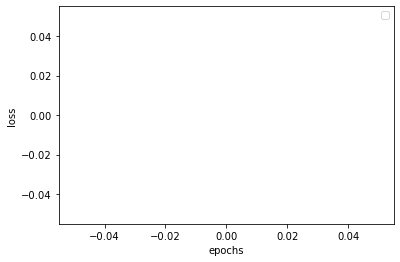

In [71]:
for label in [loss_plot,test_loss_plot]:
    plt.plot(label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [72]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['startseq']], 0) # Start token is <start> for LSTM
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id]) # Store the result or word predicted

        if tokenizer.index_word[predicted_id] == 'endseq': # if you reach <end> token then return the result
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0) # Decoder input is the word predicted at previous timestep

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [73]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()


In [74]:
len(img_name_test["mFTUGvV4Gm12mthXYlIUqw"])

TypeError: list indices must be integers or slices, not str

./data/yelp_photos/photos/m1pykkGgJ5IJa0cHAcDxlA.jpg
BELU score: 0
Real Caption: mcdonalds quarter pounder with cheese extra value meal
Prediction Caption: ['mcdonalds', 'quarter', 'pounder', 'with', 'cheese', 'extra', 'value', 'meal',
time took to Predict: 1 sec


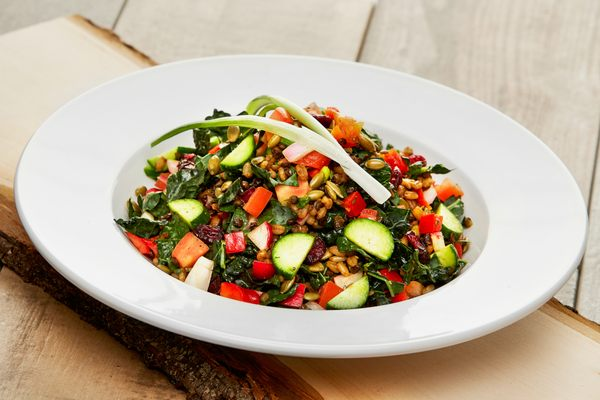

In [96]:
# captions on the validation set

from PIL import Image

from nltk.translate.bleu_score import sentence_bleu

rid = np.random.randint(0, len(img_name_test))
image = img_name_train[rid]
print(image)
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in caption_train[rid] if i not in [0]])
result, attention_plot = evaluate(image)
# result is in this format:  ['woman', 'plays', 'volleyball', '<end>']
# We need to remove <end> and join the list elements into a sentence. Also we need to remove <unk> from real_captions


first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)


#remove <end> from result         
result_join = ''.join(str(result))
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final.split()


score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

#plot_attention(image, result_final, attention_plot)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
Image.open(img_name_test[rid])

In [95]:
#perfect caption for image: ./data/yelp_photos/photos/UvCsVvKdPYRwBZD0-CQGpg.jpg

In [76]:
test_loss_plot

[]

In [79]:
train_loss = [1.151703, 1.018235, 0.959978, 0.912348, 0.859216, 0.7945236, 0.7541325, 0.71481354, 0.6815342, 0.6412345, 0.5945123, 0.5741236, 0.4741325, 0.412354, 0.374123, 0.285413, 0.2412354, 0.221845, 0.211054, 0.191564, 0.184651, 0.174651, 0.14656]
test_loss =  [0.27416483, 0.2853919, 0.2884411, 0.2852354, 0.2741535, 0.2645123, 0.2541235, 0.2202315, 0.1842135, 0.175645, 0.1647512, 0.141235, 0.140241, 0.124865, 0.110235, 0.100054, 0.0994652, 0.10025, 0.099941235, 0.081235, 0.074235, 0.0721235, 0.071325]

No handles with labels found to put in legend.


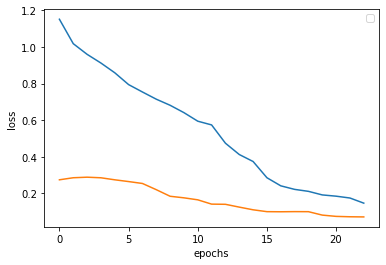

In [80]:
for label in [train_loss,test_loss]:
    plt.plot(label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [81]:
len(test_loss)

23